# Análisis de resultados ML

In [13]:
#Importando librearias
import sys
import os
import json
import tempfile
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.append('../')
sys.path.append('../../')
from sklearn.svm import SVC
from Resources.mlTracker import *
from Python.Style.styles import  *
from scipy.stats import expon, randint
from mlflow.tracking import MlflowClient
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, GroupKFold
from sklearn.metrics import make_scorer, accuracy_score, f1_score

In [14]:
#Desactivando wrnings
import warnings
warnings.filterwarnings('ignore')

In [15]:
#Utilizando diseño base 1
plt.style.use('../../Python/Style/style1.mplstyle')

In [16]:
#Colores base
#Diseño base
mClr = designC['cs']
mClr_d2 = plt.get_cmap('cs-d')(2)
sClr1 = designC['nr']
sClr1_d2 = plt.get_cmap('nr-d')(2)
sClr3 = designC['az']
sClr2 = designC['gr']
sClr2_d = plt.get_cmap('gr-d')(0)
sClr2_d2 = plt.get_cmap('gr-d')(2)
sClr4 = designC['vr']
plt.rcParams['figure.dpi'] = 120
plt.rcParams['savefig.dpi'] = 120

In [17]:
testing1 = pd.read_parquet("../../Data/DataMart/Views/TrainingViews/testing1.parquet")
testing2 = pd.read_parquet("../../Data/DataMart/Views/TrainingViews/testing2.parquet")

In [18]:
#To delete columns
total_columns = testing1.columns
tdc = ['serialNumber','serialNumber_neighbor','fixed_path','FE-Comments','Conjunto','PSNumber']
training_cols = list(filter(lambda x: x not in tdc, total_columns))
#Seleccionando columnas
testing1 = testing1[training_cols]
testing2 = testing2[training_cols]

In [19]:
#Test1
y_testing_1 = testing1['Communicating']
X_testing_1 = testing1.drop('Communicating', axis=1)
#Test2
y_testing_2 = testing2['Communicating']
X_testing_2 = testing2.drop('Communicating', axis=1)

In [20]:
#Tests dic
tests_dic = {'Test1':(X_testing_1, y_testing_1), 'Test2':(X_testing_2, y_testing_2)}

In [21]:
#Función para visualizar resultados
colorMap_t1 = plt.get_cmap('cs-c')
colorMap_t2 = plt.get_cmap('vr-c')
#Calcular métricas
def metrics(y, y_pred, cm, name):
    acc = accuracy_score(y, y_pred)
    f1_micro = f1_score(y, y_pred, average = 'micro')
    f1_macro = f1_score(y, y_pred, average = 'macro')
    f1_weighted = f1_score(y, y_pred, average='weighted')
    true_positives = cm[1,1]
    false_positives = cm[0,1]
    true_negatives = cm[0,0]
    false_negatives = cm[1,0]
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    #Diccionario
    metrics = {
        "Accuracy": acc,
        "F1 Score Micro": f1_micro,
        "F1 Score Macro": f1_macro,
        "F1 Score Weighted": f1_weighted,
        "True Positives": true_positives,
        "False Positives": false_positives,
        "True Negatives": true_negatives,
        "False Negatives": false_negatives,
        "Precision": precision,
        "Recall": recall
    }
    #Imprimir
    print(f"Metrics for {name}")
    print(f"Accuracy: {acc}")
    print(f"F1 Score Micro: {f1_micro}")
    print(f"F1 Score Macro: {f1_macro}")
    print(f"F1 Score Weighted: {f1_weighted}")
    print(f"Precission: {precision}")
    print(f"Recall: {recall}")
    return metrics

#Función
def metrics_and_cmatrix(model, tests_dic, name, cMaps = {'Test1':colorMap_t1,'Test2':colorMap_t2}):
    classes = ["No Communicating", "Communicating"]
    #Calculos para test1
    X_test1, y_test1 = tests_dic['Test1']
    y_pred = model.predict(X_test1)
    cm1 = confusion_matrix(y_test1, y_pred)
    cm1_normalized = cm1.astype('float') / cm1.sum(axis=1)[:, np.newaxis]
    #Calculando métricas
    metrics_test1 = metrics(y_test1, y_pred, cm1, f"{name} Test 1")
    #Calculos para test2
    X_test2, y_test2 = tests_dic['Test2']
    y_pred2 = model.predict(X_test2)
    cm2 = confusion_matrix(y_test2, y_pred2)
    cm2_normalized = cm2.astype('float') / cm2.sum(axis=1)[:, np.newaxis]
    #Calculando métricas
    metrics_test2 = metrics(y_test2, y_pred2, cm2, f"{name} Test 2")
    #Visualización para test1
    fig, axs = plt.subplots(1, 2, figsize=(10,5))
    sns.heatmap(cm1, annot=True, fmt='d', linewidths=.5, cmap=cMaps['Test1'], xticklabels=classes, yticklabels=classes, ax=axs[0])
    axs[0].set_title(f"Matriz de Confusión")
    sns.heatmap(cm1_normalized, annot=True, fmt='.2f', linewidths=.5, cmap=cMaps['Test1'], xticklabels=classes, yticklabels=classes, ax=axs[1])
    axs[1].set_title(f"Matriz de Confusión Normalizada")
    plt.suptitle(f"{name} Test1")
    fig.text(0.5, 0.04, 'Etiqueta predicha', ha='center', va='center', color = sClr2_d2)
    fig.text(0.06, 0.5, 'Etiqueta verdadera', ha='center', va='center', rotation = 90,color=sClr2_d2)
    #Ajustando
    plt.tight_layout(rect=[0.98, 0.95, 0.25, 0.95])
    plt.savefig(f'../../Python/PythonGImages/results/cm_visualization_{name}_test1.png')
    plt.show()
    #Visualización para test2
    fig, axs = plt.subplots(1, 2, figsize=(10,5))
    sns.heatmap(cm2, annot=True, fmt='d', linewidths=.5, cmap=cMaps['Test2'], xticklabels=classes, yticklabels=classes, ax=axs[0])
    axs[0].set_title(f"Matriz de Confusión")
    sns.heatmap(cm2_normalized, annot=True, fmt='.2f', linewidths=.5, cmap=cMaps['Test2'], xticklabels=classes, yticklabels=classes, ax=axs[1])
    axs[1].set_title(f"Matriz de Confusión Normalizada")
    plt.suptitle(f"{name} Test2")
    fig.text(0.5, 0.04, 'Etiqueta predicha', ha='center', va='center', color = sClr2_d2)
    fig.text(0.06, 0.5, 'Etiqueta verdadera', ha='center', va='center', rotation = 90,color=sClr2_d2)
    #Ajustando
    plt.tight_layout(rect=[0.98, 0.95, 0.25, 0.95])
    plt.savefig(f'../../Python/PythonGImages/results/cm_visualization_{name}_test2.png')
    plt.show()
    #Logeando métricas
    with mlflow.start_run(run_name=f"{name} Test1"):
        mlflow.log_param("Test", "1")
        mlflow.log_metrics(metrics_test1)
    with mlflow.start_run(run_name=f"{name} Test2"):
        mlflow.log_param("Test", "2")
        mlflow.log_metrics(metrics_test2)
        

In [22]:
#Set experiment
experiment_name = "Results ML"
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='file:///Users/victor.borrayo/Desktop/Tesis/trabajoGrad/Training/mlruns/650966590368091469', creation_time=1717767368987, experiment_id='650966590368091469', last_update_time=1717767368987, lifecycle_stage='active', name='Results ML', tags={}>

## KNN

In [23]:
#KNN ML training
temp_id = get_run_id("ML", "KNN-Training")
temp_randomized_search = mlflow.sklearn.load_model(f"runs:/{temp_id}/RandomizedSearchCV")
temp_model = temp_randomized_search.best_estimator_
metrics_and_cmatrix(temp_model, tests_dic, "ML-KNN-Training")

Metrics for ML-KNN-Training Test 1
Accuracy: 0.9810077883081543
F1 Score Micro: 0.9810077883081543
F1 Score Macro: 0.8742939052926972
F1 Score Weighted: 0.9807947735299587
Precission: 0.9891684068775737
Recall: 0.9910639213155785


Metrics for ML-KNN-Training-Undersampled Test 1
Accuracy: 0.857089237121141
F1 Score Micro: 0.857089237121141
F1 Score Macro: 0.627467482511822
F1 Score Weighted: 0.8964060757755024
Precission: 0.9948610668970849
Recall: 0.855517099782953
Metrics for ML-KNN-Training-Undersampled Test 2
Accuracy: 0.823407290419543
F1 Score Micro: 0.823407290419543
F1 Score Macro: 0.5413461617601918
F1 Score Weighted: 0.8644124578300098
Precission: 0.962526880900453
Recall: 0.8469094715370783


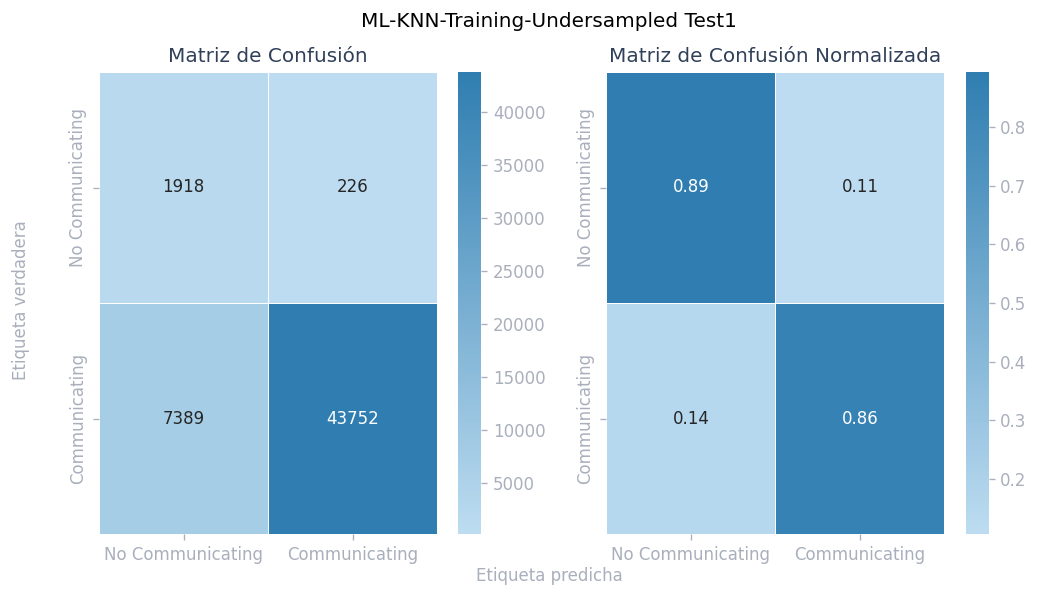

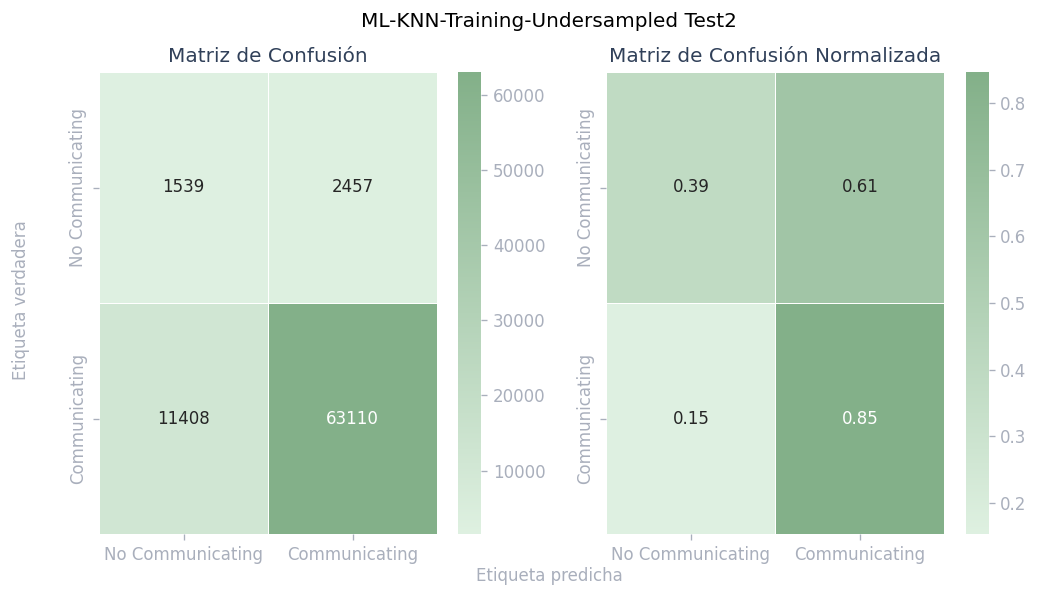

In [ ]:
#KNN ML training
temp_id = get_run_id("ML", "KNN-Training-Undersampled")
temp_randomized_search = mlflow.sklearn.load_model(f"runs:/{temp_id}/RandomizedSearchCV")
temp_model = temp_randomized_search.best_estimator_
metrics_and_cmatrix(temp_model, tests_dic, "ML-KNN-Training-Undersampled")

### KNN ML2

Metrics for ML2-KNN-Undersampled Test 1
Accuracy: 0.7653373369616214
F1 Score Micro: 0.7653373369616214
F1 Score Macro: 0.5505203678938632
F1 Score Weighted: 0.8362490383451202
Precission: 0.9955875939560299
Recall: 0.7588627519993743
Metrics for ML2-KNN-Undersampled Test 2
Accuracy: 0.7467967496242708
F1 Score Micro: 0.7467967496242707
F1 Score Macro: 0.5084900473532873
F1 Score Weighted: 0.8158956675756084
Precission: 0.9656700644325503
Recall: 0.76024584664108


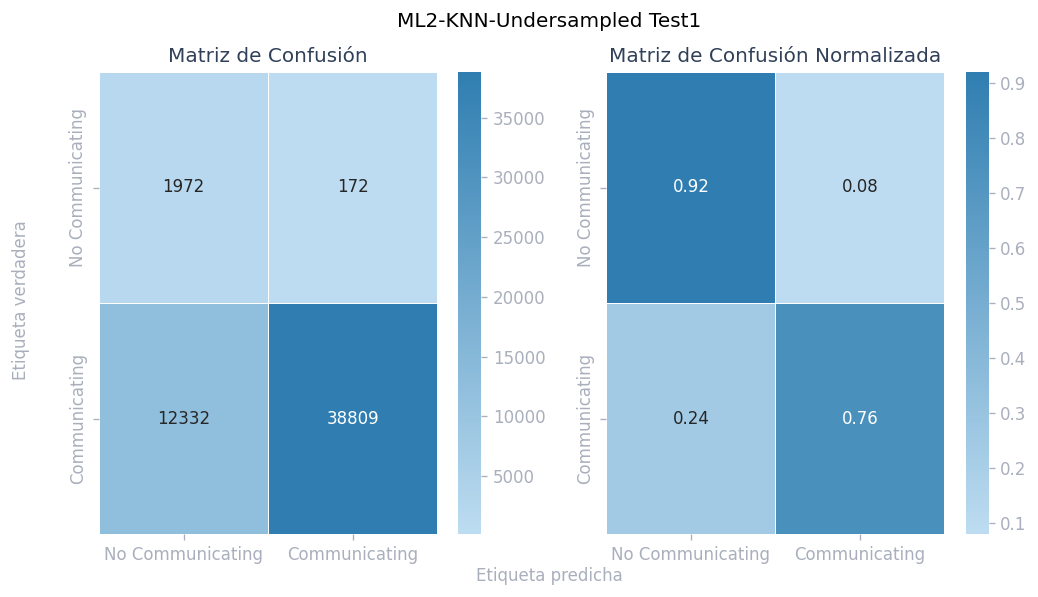

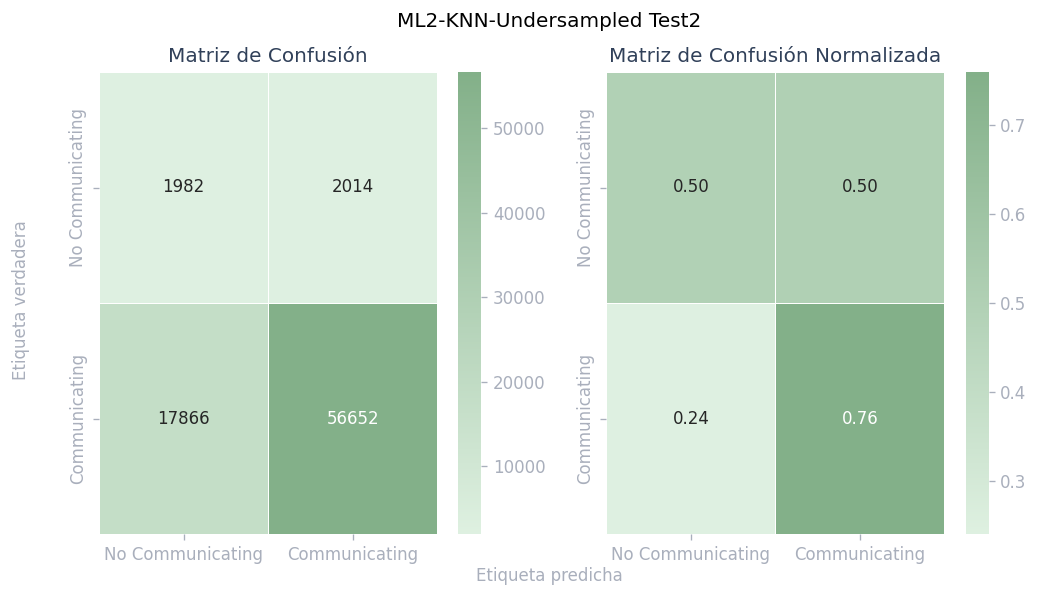

In [ ]:
#KNN ML2 undersampled
temp_id = get_run_id("ML-2", "KNN-Undersampled")
temp_randomized_search = mlflow.sklearn.load_model(f"runs:/{temp_id}/RandomizedSearchCV")
temp_model = temp_randomized_search.best_estimator_
metrics_and_cmatrix(temp_model, tests_dic, "ML2-KNN-Undersampled")

Metrics for ML2-KNN-Oversampled Test 1
Accuracy: 0.9470582715586
F1 Score Micro: 0.9470582715586
F1 Score Macro: 0.767465822316771
F1 Score Weighted: 0.9553767139948675
Precission: 0.9933431348525689
Recall: 0.9512133122152481
Metrics for ML2-KNN-Oversampled Test 2
Accuracy: 0.8997376264105764
F1 Score Micro: 0.8997376264105764
F1 Score Macro: 0.5808792635831252
F1 Score Weighted: 0.9092360502324275
Precission: 0.959767101741218
Recall: 0.9334925789742076


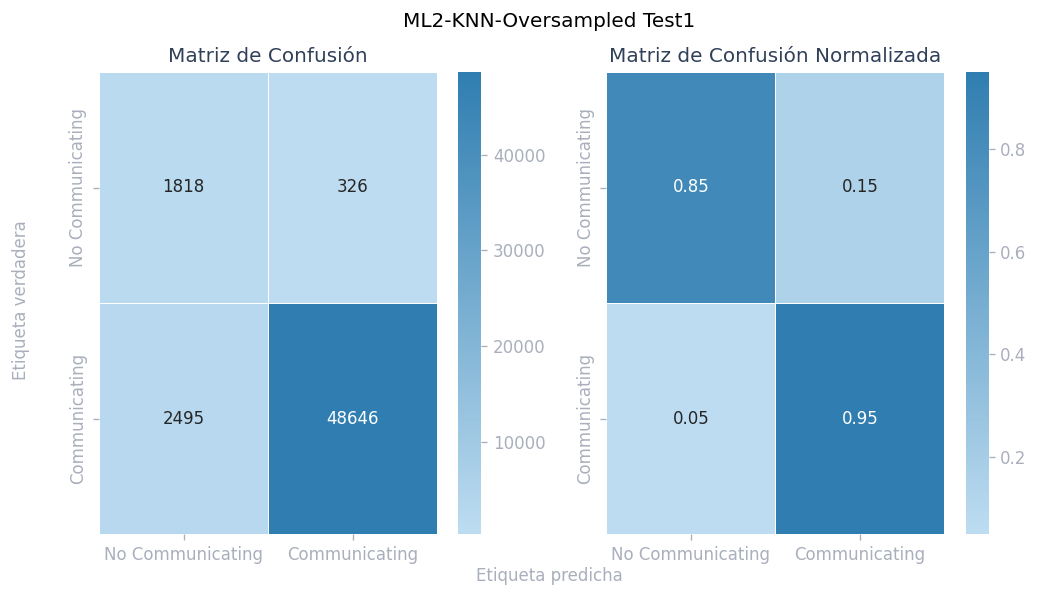

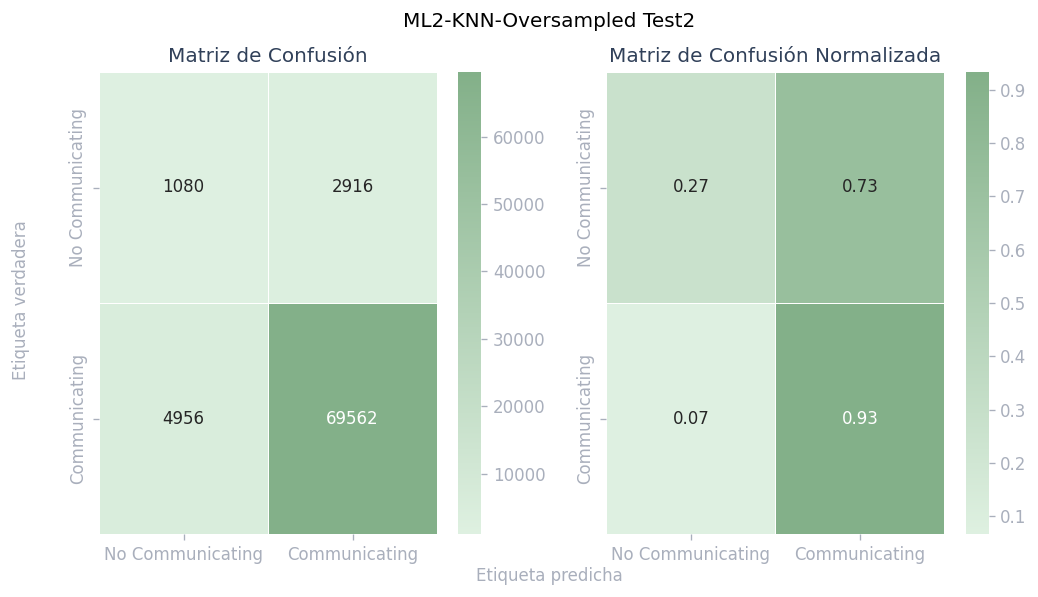

In [ ]:
#KNN ML2 Oversampled
temp_id = get_run_id("ML-2", "KNN-Oversampled")
temp_randomized_search = mlflow.sklearn.load_model(f"runs:/{temp_id}/RandomizedSearchCV")
temp_model = temp_randomized_search.best_estimator_
metrics_and_cmatrix(temp_model, tests_dic, "ML2-KNN-Oversampled")

### KNN ML3

Metrics for ML3-KNN-Undersampled Test 1
Accuracy: 0.7703481279909918
F1 Score Micro: 0.7703481279909918
F1 Score Macro: 0.5487135642929931
F1 Score Weighted: 0.8395236097514809
Precission: 0.9926302993466039
Recall: 0.7664105121135684
Metrics for ML3-KNN-Undersampled Test 2
Accuracy: 0.750299309677255
F1 Score Micro: 0.7502993096772551
F1 Score Macro: 0.5137979992776873
F1 Score Weighted: 0.8183788976140032
Precission: 0.9673049102204068
Recall: 0.7626882095601063


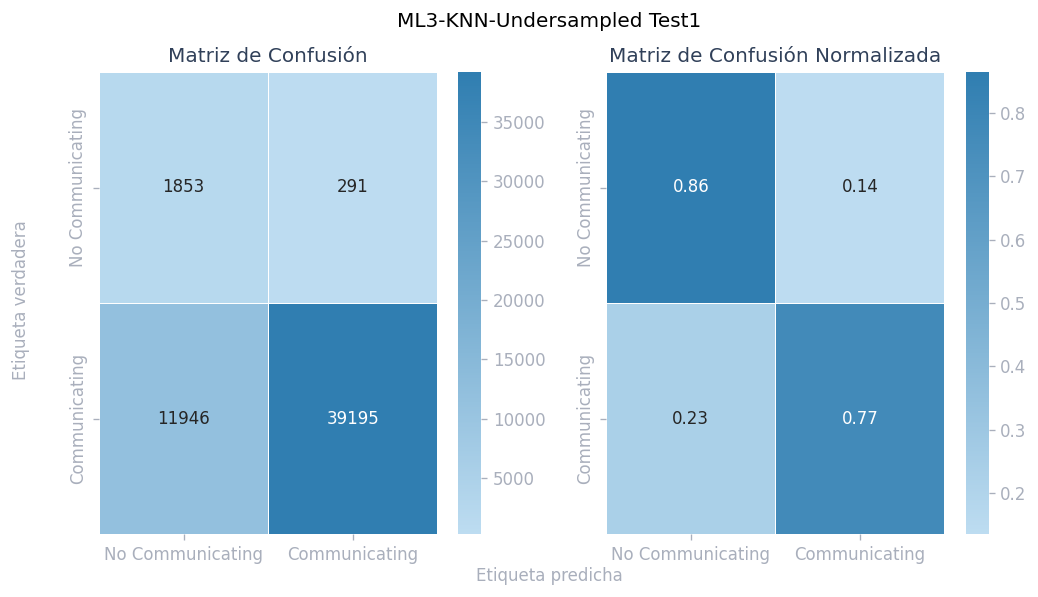

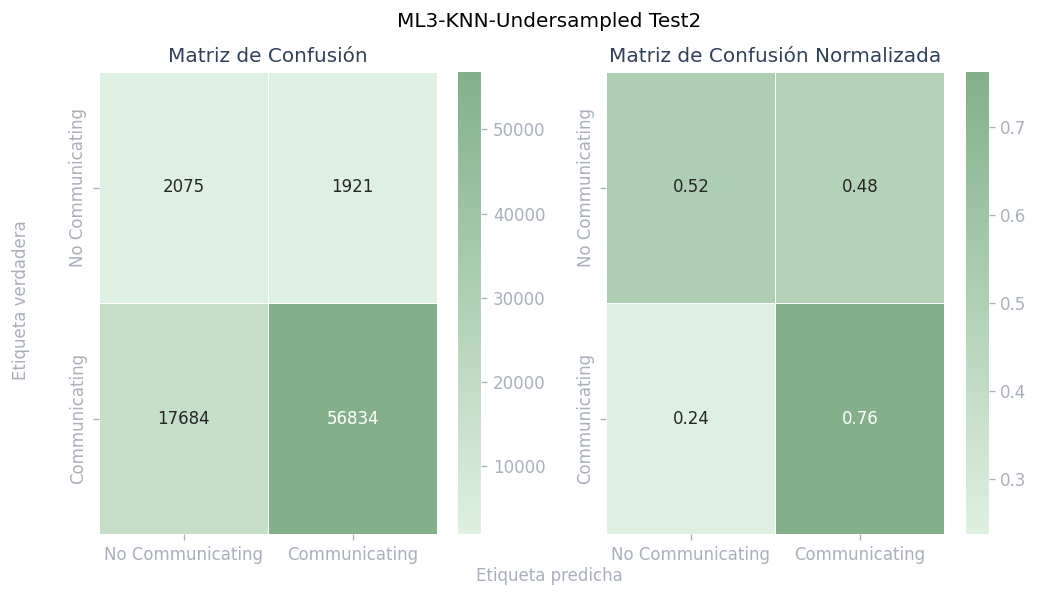

In [ ]:
#KNN ML2 undersampled
temp_id = get_run_id("ML-3", "KNN-Undersampled")
temp_randomized_search = mlflow.sklearn.load_model(f"runs:/{temp_id}/RandomizedSearchCV")
temp_model = temp_randomized_search.best_estimator_
metrics_and_cmatrix(temp_model, tests_dic, "ML3-KNN-Undersampled")

Metrics for ML3-KNN-Oversampled Test 1
Accuracy: 0.9199962465984799
F1 Score Micro: 0.9199962465984799
F1 Score Macro: 0.7134187248238428
F1 Score Weighted: 0.9371516787228678
Precission: 0.9946606449434409
Recall: 0.9215893314561702
Metrics for ML3-KNN-Oversampled Test 2
Accuracy: 0.8751178133836004
F1 Score Micro: 0.8751178133836004
F1 Score Macro: 0.5656415905762048
F1 Score Weighted: 0.8949594452805814
Precission: 0.9604662084276139
Recall: 0.9057006360879251


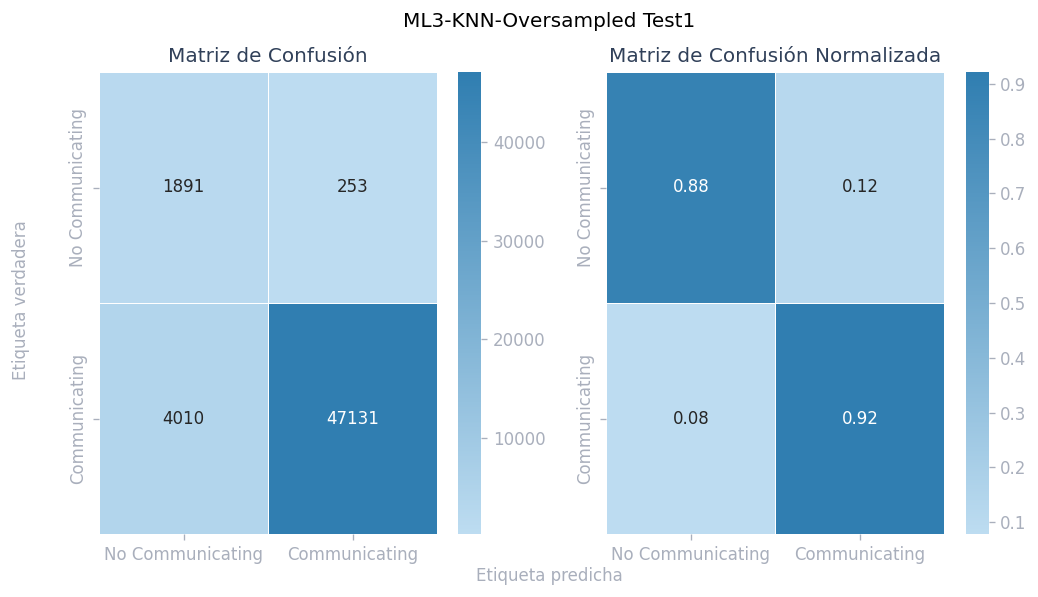

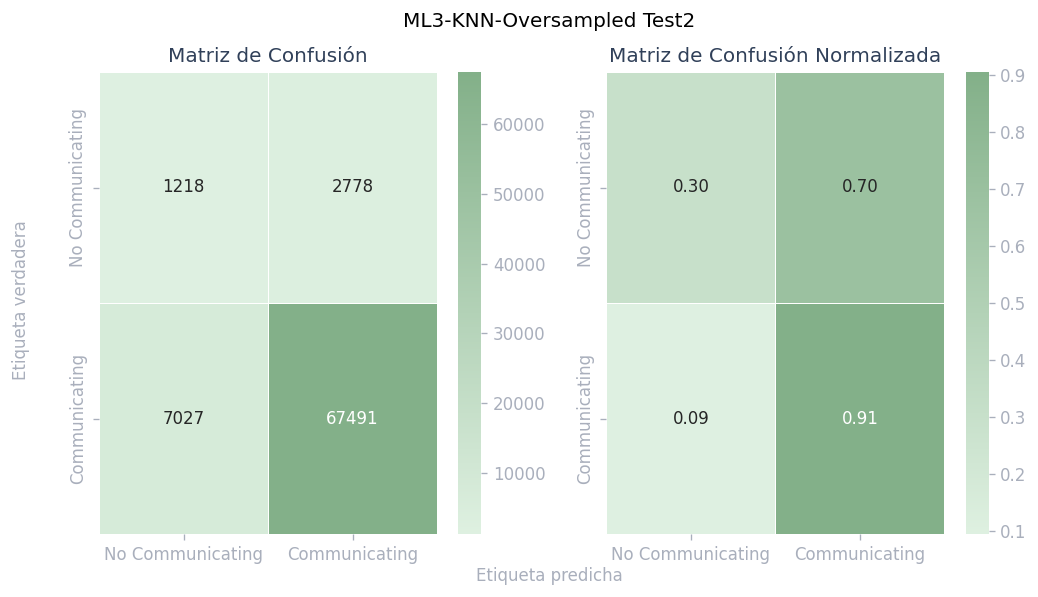

In [ ]:
#KNN ML2 undersampled
temp_id = get_run_id("ML-3", "KNN-Oversampled")
temp_randomized_search = mlflow.sklearn.load_model(f"runs:/{temp_id}/RandomizedSearchCV")
temp_model = temp_randomized_search.best_estimator_
metrics_and_cmatrix(temp_model, tests_dic, "ML3-KNN-Oversampled")

## Random Forest

### Random forest ML

Metrics for ML-RF-Training Test 1
Accuracy: 0.9956272872290514
F1 Score Micro: 0.9956272872290514
F1 Score Macro: 0.9710511601555225
F1 Score Weighted: 0.9955777305120015
Precission: 0.996760343481655
Recall: 0.9986898965604897
Metrics for ML-RF-Training Test 2
Accuracy: 0.9507603739460478
F1 Score Micro: 0.9507603739460478
F1 Score Macro: 0.5323101556119123
F1 Score Weighted: 0.9296648845236608
Precission: 0.9513812578262758
Recall: 0.9991814058348318


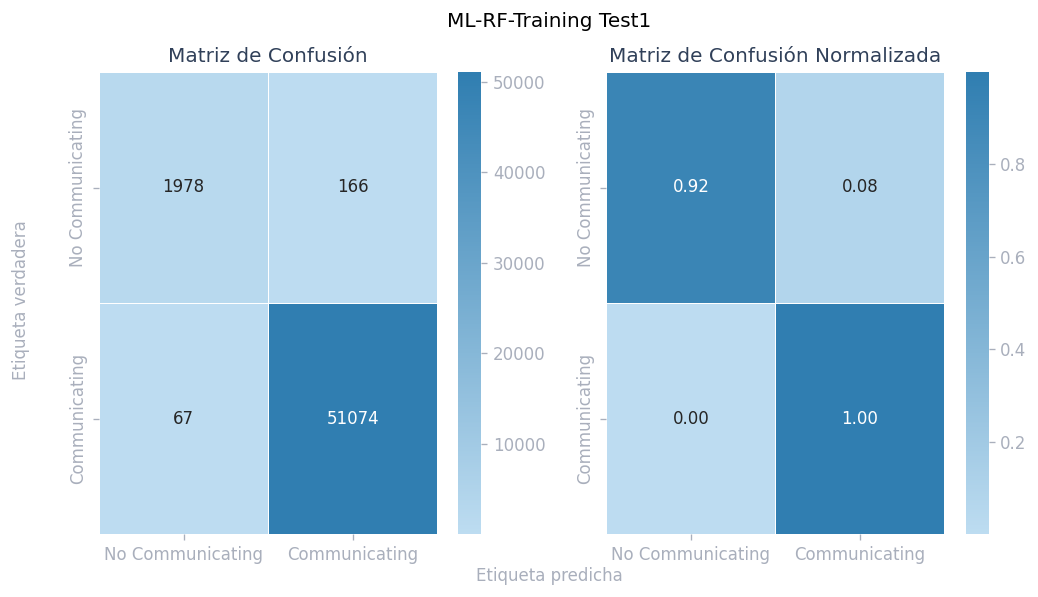

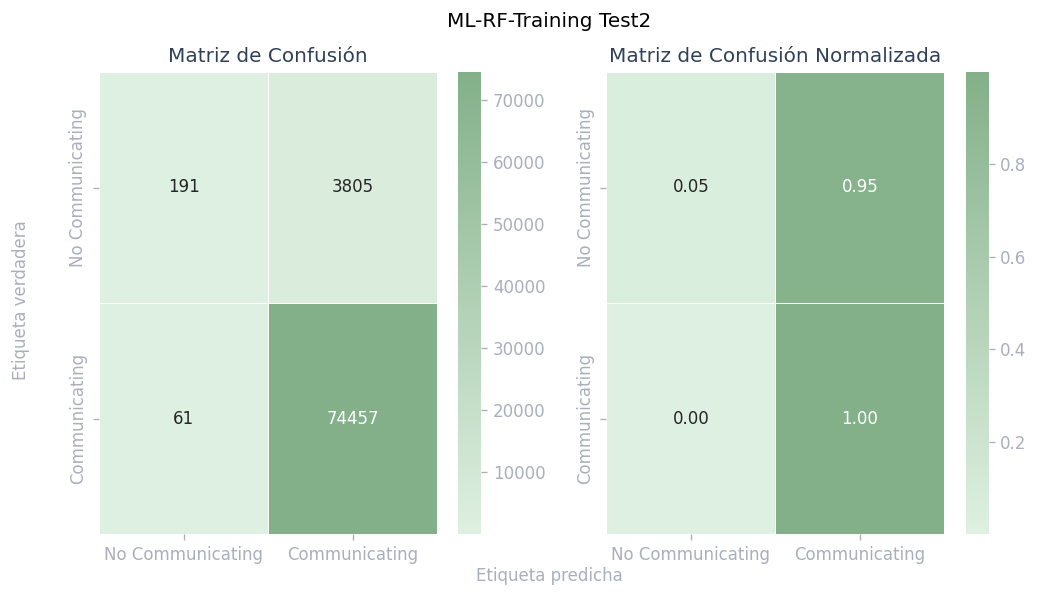

In [ ]:
#RF ML Training
temp_id = get_run_id("ML", "RF-Training")
temp_randomized_search = mlflow.sklearn.load_model(f"runs:/{temp_id}/RandomizedSearchCV")
temp_model = temp_randomized_search.best_estimator_
metrics_and_cmatrix(temp_model, tests_dic, "ML-RF-Training")

Metrics for ML-RF-Training-Undersampled Test 1
Accuracy: 0.9870507647555598
F1 Score Micro: 0.9870507647555598
F1 Score Macro: 0.9258237856733549
F1 Score Weighted: 0.9877918981703242
Precission: 0.9989714172683216
Recall: 0.9875246866506325
Metrics for ML-RF-Training-Undersampled Test 2
Accuracy: 0.9487352574063225
F1 Score Micro: 0.9487352574063225
F1 Score Macro: 0.6608536139977463
F1 Score Weighted: 0.9415120496041387
Precission: 0.9617465578452308
Recall: 0.9851713679916262


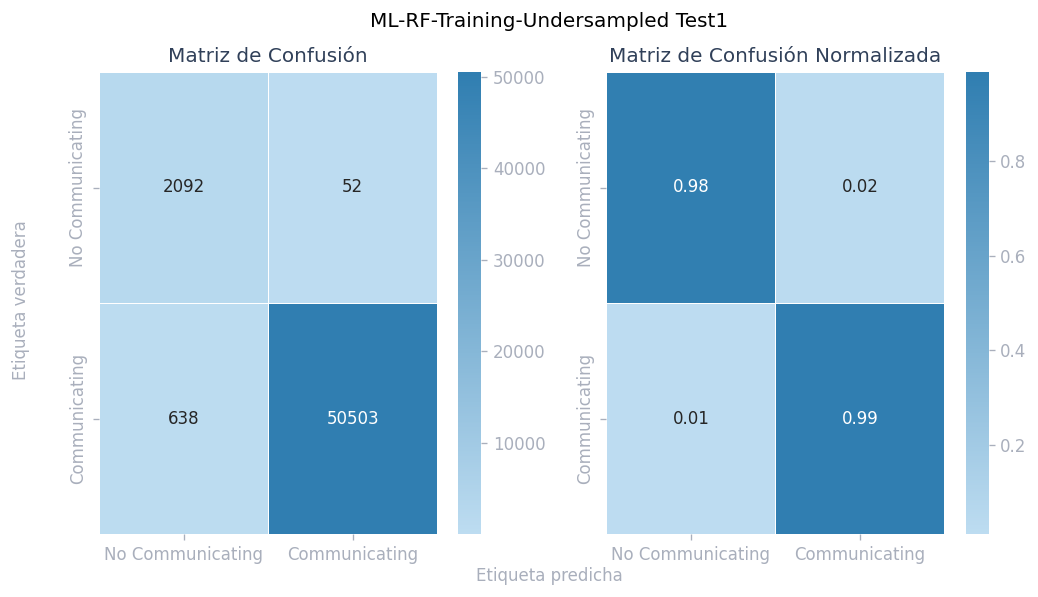

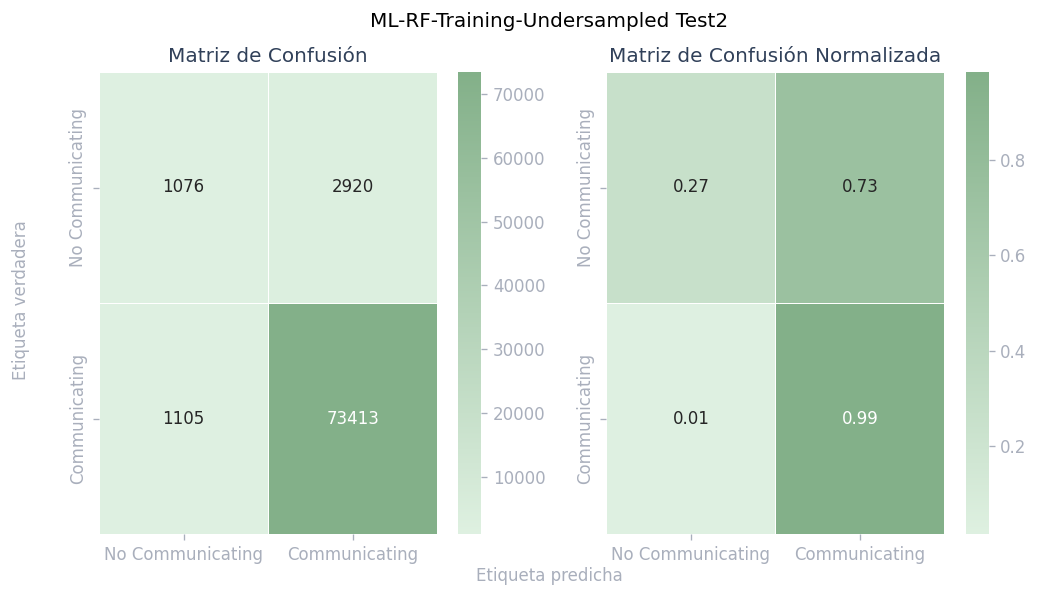

In [ ]:
#RF ML Undersampled
temp_id = get_run_id("ML", "RF-Training-Undersampled")
temp_randomized_search = mlflow.sklearn.load_model(f"runs:/{temp_id}/RandomizedSearchCV")
temp_model = temp_randomized_search.best_estimator_
metrics_and_cmatrix(temp_model, tests_dic, "ML-RF-Training-Undersampled")

Metrics for ML-RF-Training-Oversampled Test 1
Accuracy: 0.9974664539739139
F1 Score Micro: 0.9974664539739139
F1 Score Macro: 0.9836021191319406
F1 Score Weighted: 0.9974667369426224
Precission: 0.9986898709425107
Recall: 0.9986703427778104
Metrics for ML-RF-Training-Oversampled Test 2
Accuracy: 0.9502891204116464
F1 Score Micro: 0.9502891204116464
F1 Score Macro: 0.5409551240325003
F1 Score Weighted: 0.9303085464661086
Precission: 0.9518665932912704
Recall: 0.9980944201401004


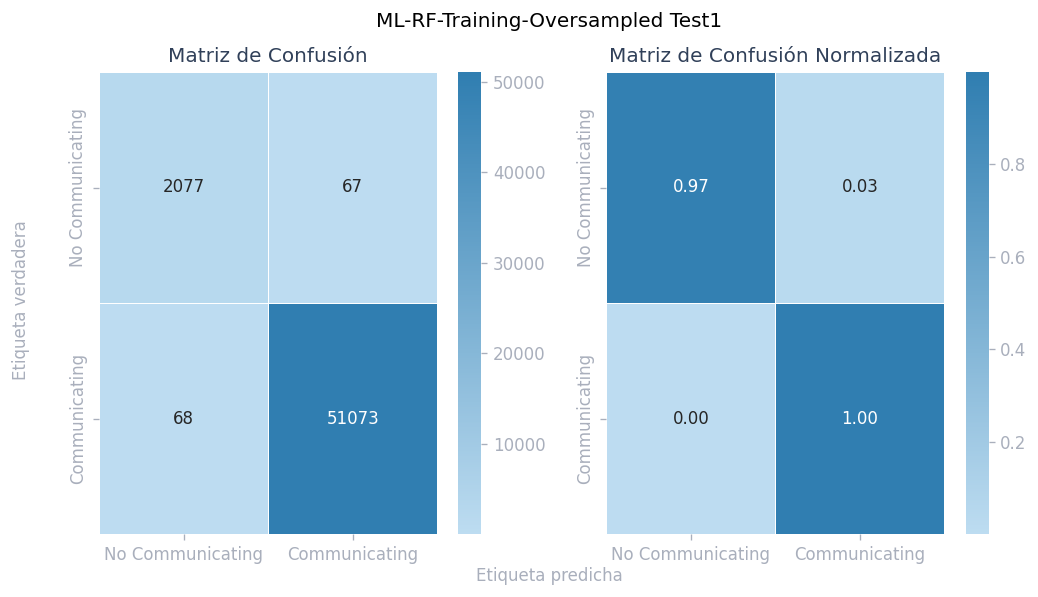

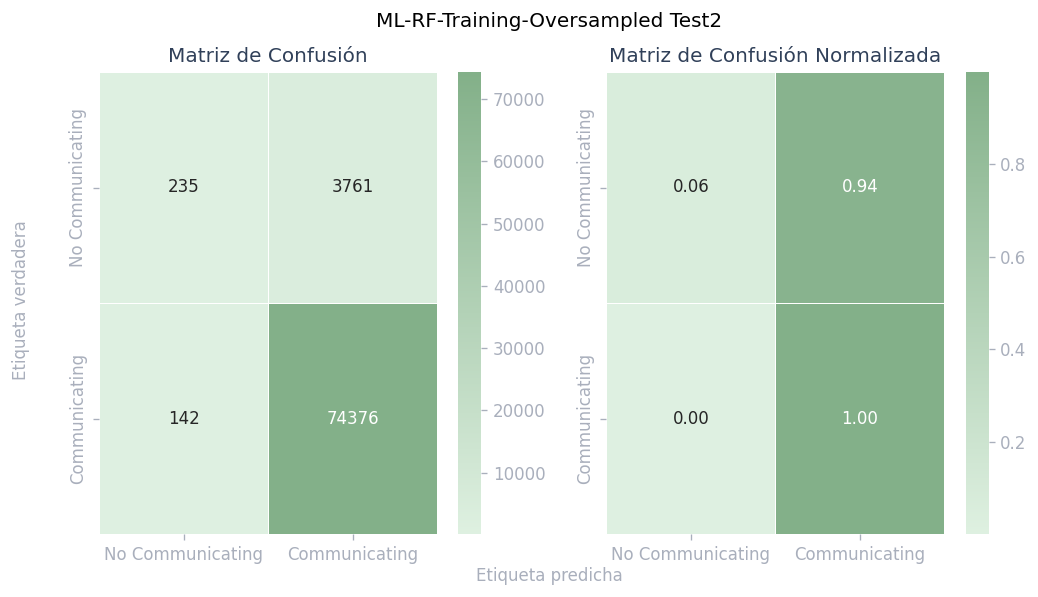

In [ ]:
#RF ML Oversampled
temp_id = get_run_id("ML", "RF-Training-Oversampled")
temp_randomized_search = mlflow.sklearn.load_model(f"runs:/{temp_id}/RandomizedSearchCV")
temp_model = temp_randomized_search.best_estimator_
metrics_and_cmatrix(temp_model, tests_dic, "ML-RF-Training-Oversampled")

Metrics for ML2-RF-Training-Undersampled Test 1
Accuracy: 0.852115980106972
F1 Score Micro: 0.852115980106972
F1 Score Macro: 0.6122676581957869
F1 Score Weighted: 0.8926811309267596
Precission: 0.9910108278664336
Recall: 0.8536594904284234
Metrics for ML2-RF-Training-Undersampled Test 2
Accuracy: 0.8392133886950098
F1 Score Micro: 0.8392133886950097
F1 Score Macro: 0.5907170473439616
F1 Score Weighted: 0.8771673887209048
Precission: 0.9748365912787308
Recall: 0.8525993719638209


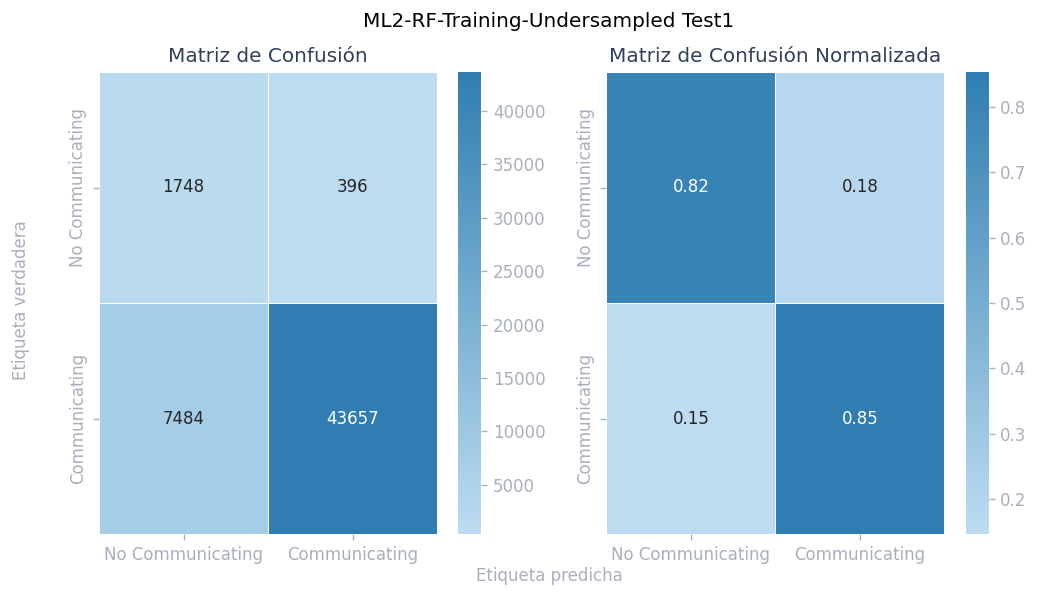

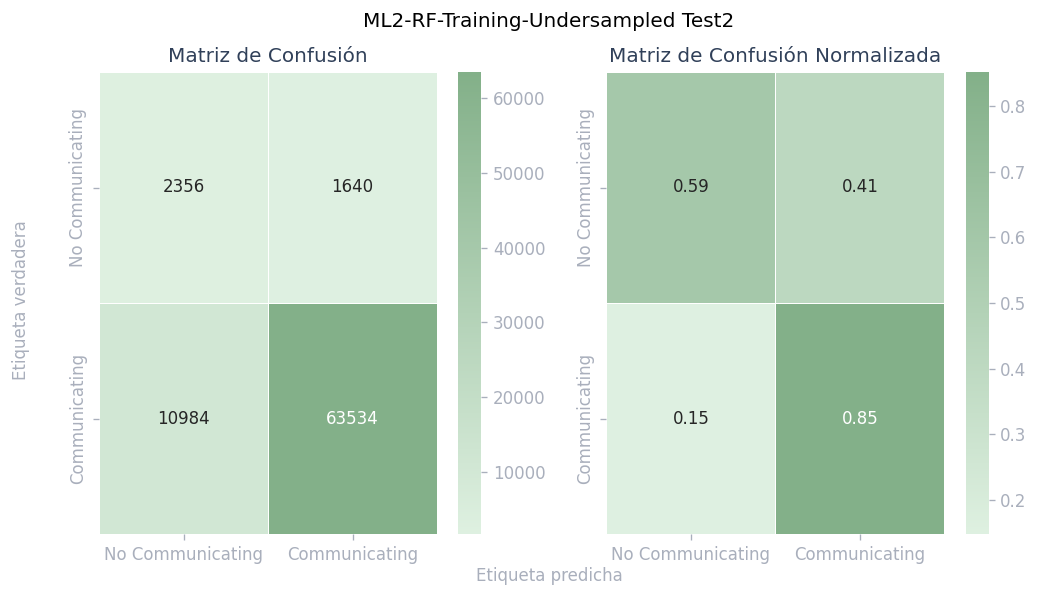

In [ ]:
#RF ML Oversampled
temp_id = get_run_id("ML-2", "RF-Training-Undersampled")
temp_randomized_search = mlflow.sklearn.load_model(f"runs:/{temp_id}/RandomizedSearchCV")
temp_model = temp_randomized_search.best_estimator_
metrics_and_cmatrix(temp_model, tests_dic, "ML2-RF-Training-Undersampled")

Metrics for ML2-RF-Training-Oversampled Test 1
Accuracy: 0.8840949610584592
F1 Score Micro: 0.8840949610584592
F1 Score Macro: 0.651837324454422
F1 Score Weighted: 0.9133186190176905
Precission: 0.9923354866965948
Recall: 0.8860796621106353
Metrics for ML2-RF-Training-Oversampled Test 2
Accuracy: 0.8625085971928573
F1 Score Micro: 0.8625085971928573
F1 Score Macro: 0.5838714552672037
F1 Score Weighted: 0.8897230673717524
Precission: 0.9668830502762188
Recall: 0.8854639147588502


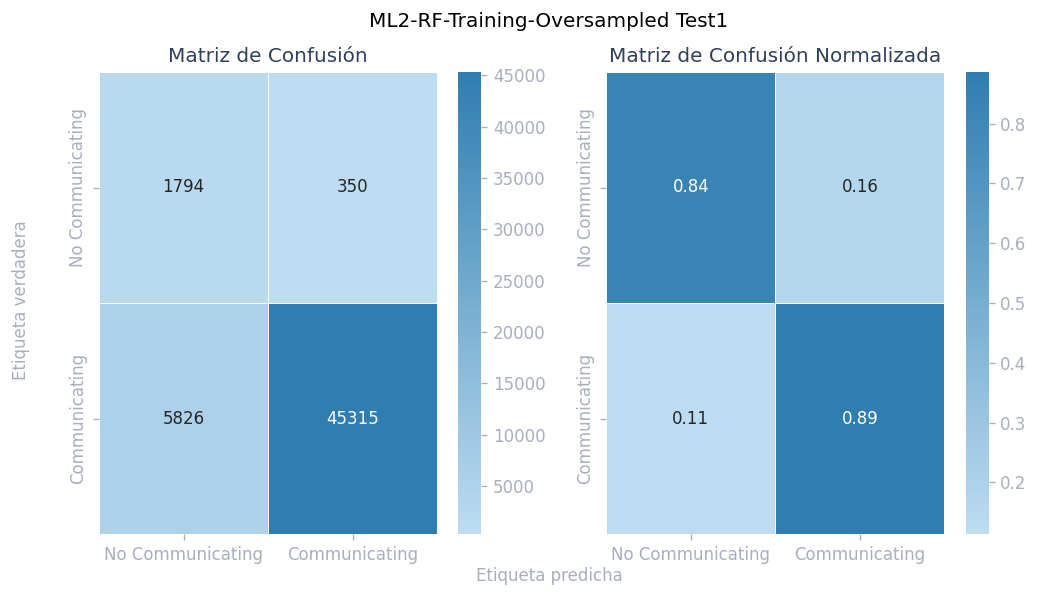

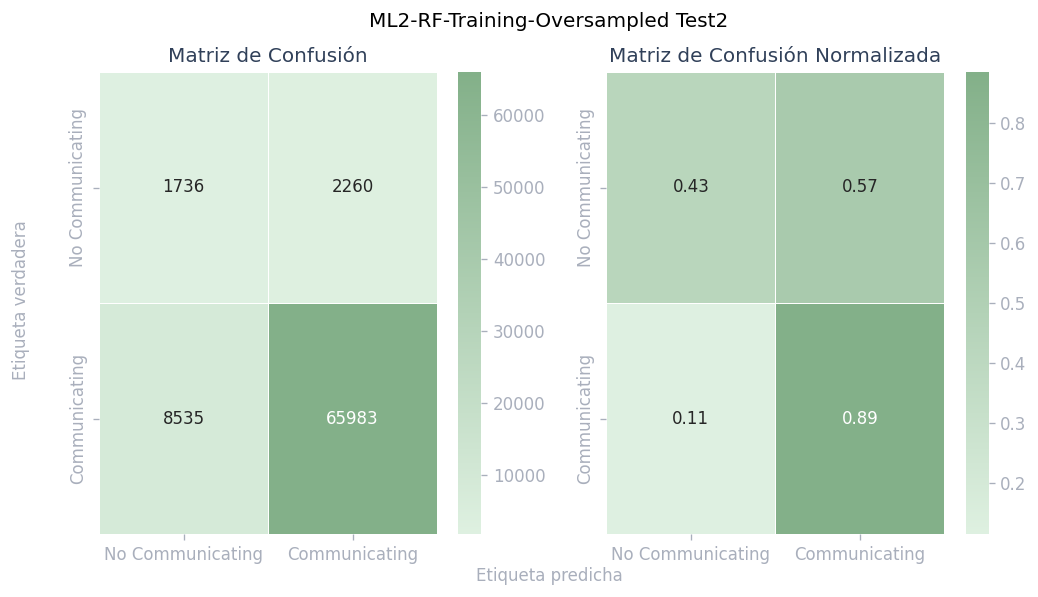

In [ ]:
#RF ML Oversampled
temp_id = get_run_id("ML-2", "RF-Training-Oversampled")
temp_randomized_search = mlflow.sklearn.load_model(f"runs:/{temp_id}/RandomizedSearchCV")
temp_model = temp_randomized_search.best_estimator_
metrics_and_cmatrix(temp_model, tests_dic, "ML2-RF-Training-Oversampled")

## Gradient Boost Classifier

### Gradient Boost Classifier ML

Metrics for ML-GBC-Training-Undersampled Test 1
Accuracy: 0.9910481373744956
F1 Score Micro: 0.9910481373744956
F1 Score Macro: 0.9469679113648417
F1 Score Weighted: 0.9914265123075141
Precission: 0.999408563993376
Recall: 0.9912594591423711
Metrics for ML-GBC-Training-Undersampled Test 2
Accuracy: 0.9468629798507272
F1 Score Micro: 0.9468629798507272
F1 Score Macro: 0.5754801496781826
F1 Score Weighted: 0.9321262081430798
Precission: 0.9542437235251575
Recall: 0.9915590863952334


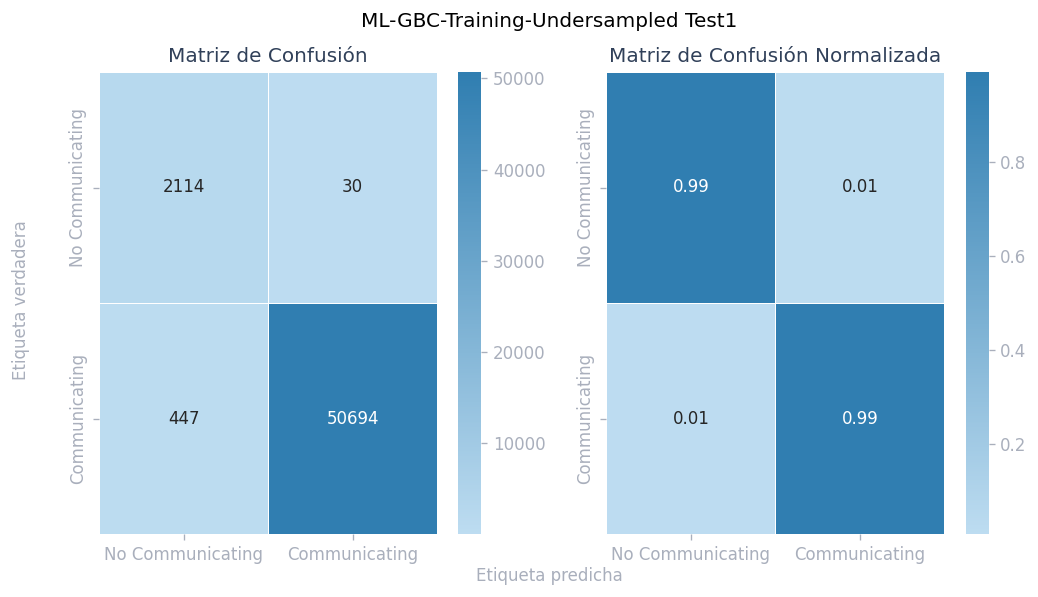

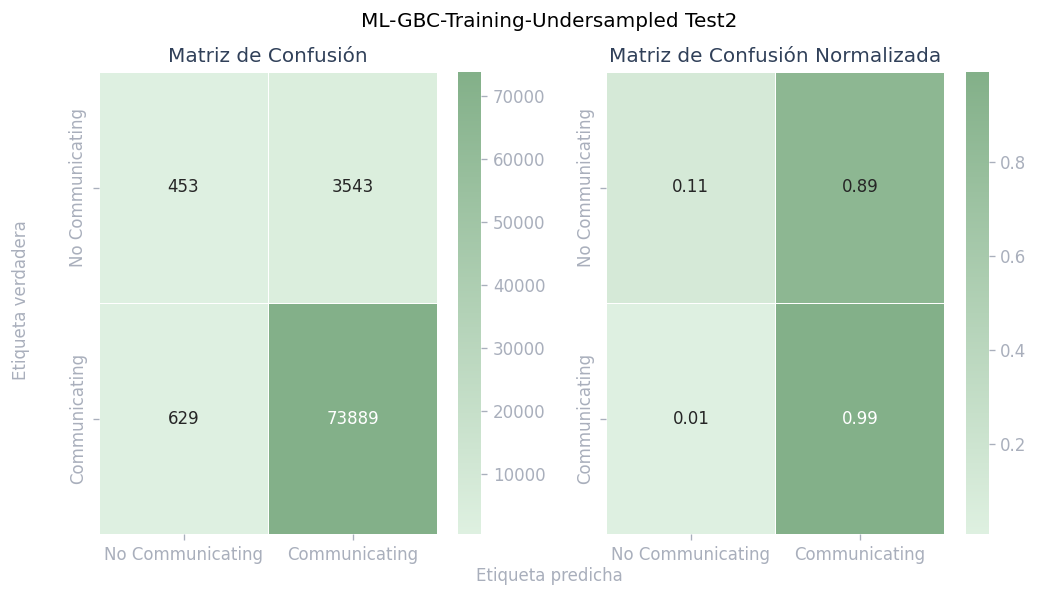

In [ ]:
#GBC ML Oversampled
temp_id = get_run_id("ML", "gbc_training_undersampled")
temp_randomized_search = mlflow.sklearn.load_model(f"runs:/{temp_id}/RandomizedSearchCV")
temp_model = temp_randomized_search.best_estimator_
metrics_and_cmatrix(temp_model, tests_dic, "ML-GBC-Training-Undersampled")

Metrics for ML-GBC-Training-Oversampled Test 1
Accuracy: 0.9937881204841887
F1 Score Micro: 0.9937881204841887
F1 Score Macro: 0.9617389312230621
F1 Score Weighted: 0.9939386139294972
Precission: 0.9989982715273413
Recall: 0.9945249408498074
Metrics for ML-GBC-Training-Oversampled Test 2
Accuracy: 0.947563491861324
F1 Score Micro: 0.947563491861324
F1 Score Macro: 0.5991315235203688
F1 Score Weighted: 0.9348207989386239
Precission: 0.9559945592331109
Recall: 0.9903379049357203


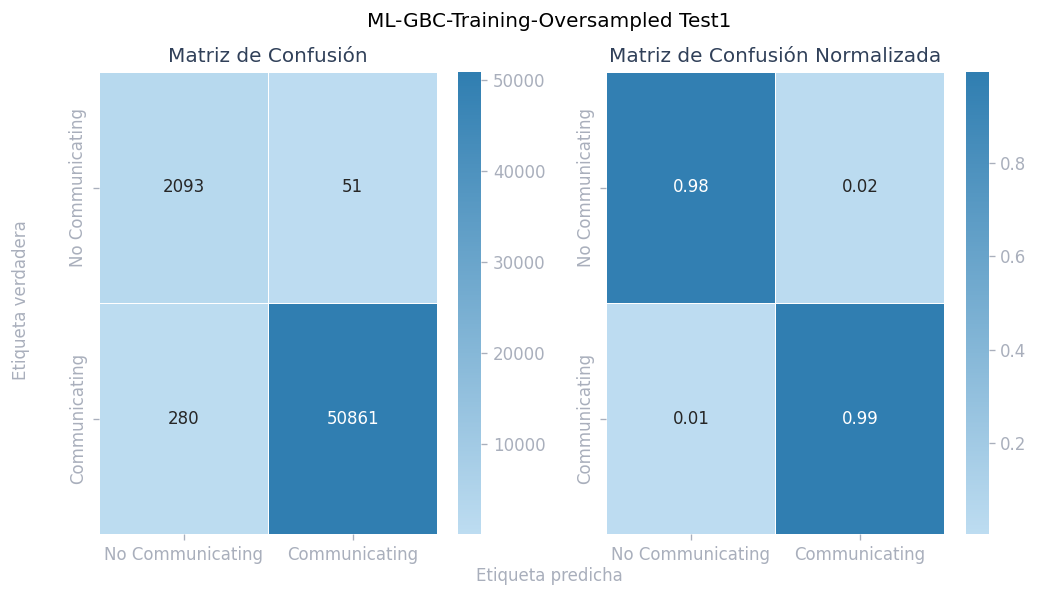

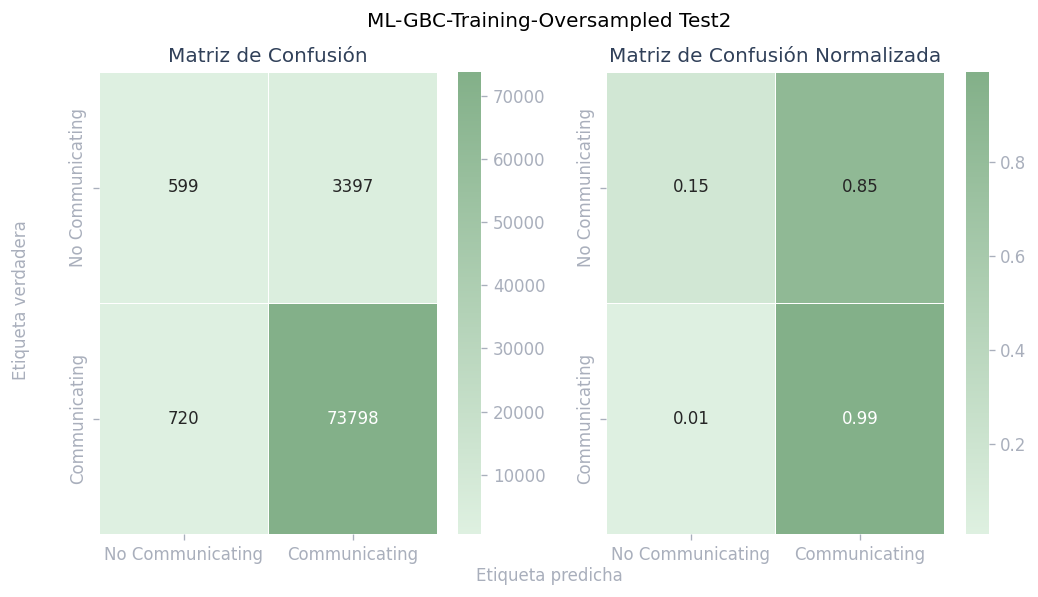

In [ ]:
#GBC ML Oversampled
temp_id = get_run_id("ML", "gbc_training_oversampled")
temp_randomized_search = mlflow.sklearn.load_model(f"runs:/{temp_id}/RandomizedSearchCV")
temp_model = temp_randomized_search.best_estimator_
metrics_and_cmatrix(temp_model, tests_dic, "ML-GBC-Training-Oversampled")

### Gradient Boost Classifier ML2

Metrics for ML2-GBC-Training-Undersampled Test 1
Accuracy: 0.9512996152763442
F1 Score Micro: 0.9512996152763442
F1 Score Macro: 0.7919310356318704
F1 Score Weighted: 0.9593750099175906
Precission: 0.9976218787158145
Recall: 0.9515261727381162
Metrics for ML2-GBC-Training-Undersampled Test 2
Accuracy: 0.9147795297653921
F1 Score Micro: 0.9147795297653921
F1 Score Macro: 0.6097871477716484
F1 Score Weighted: 0.9196523425184939
Precission: 0.9619801386750944
Recall: 0.9476636517351512


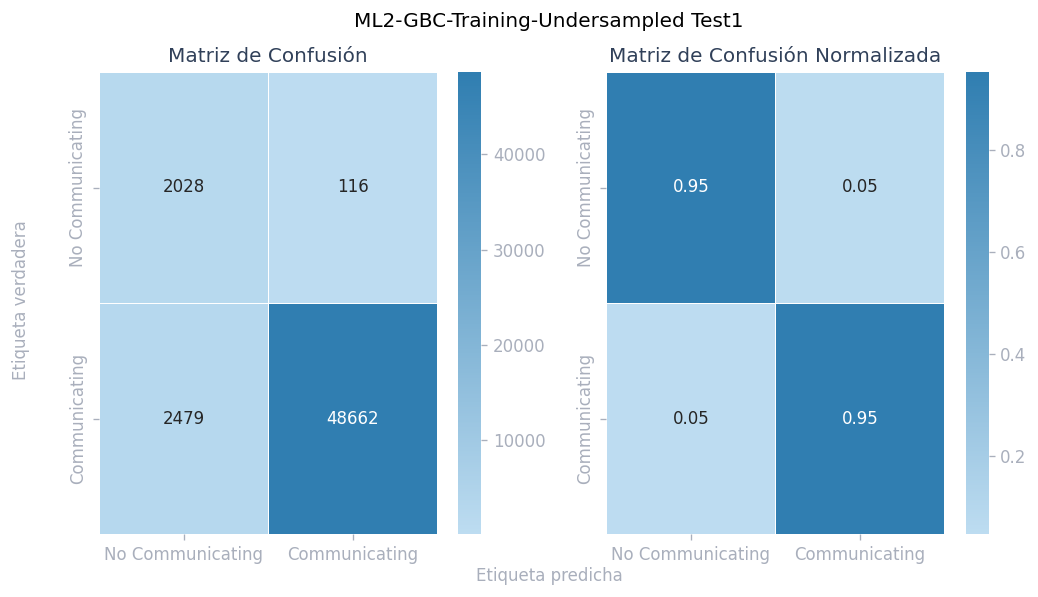

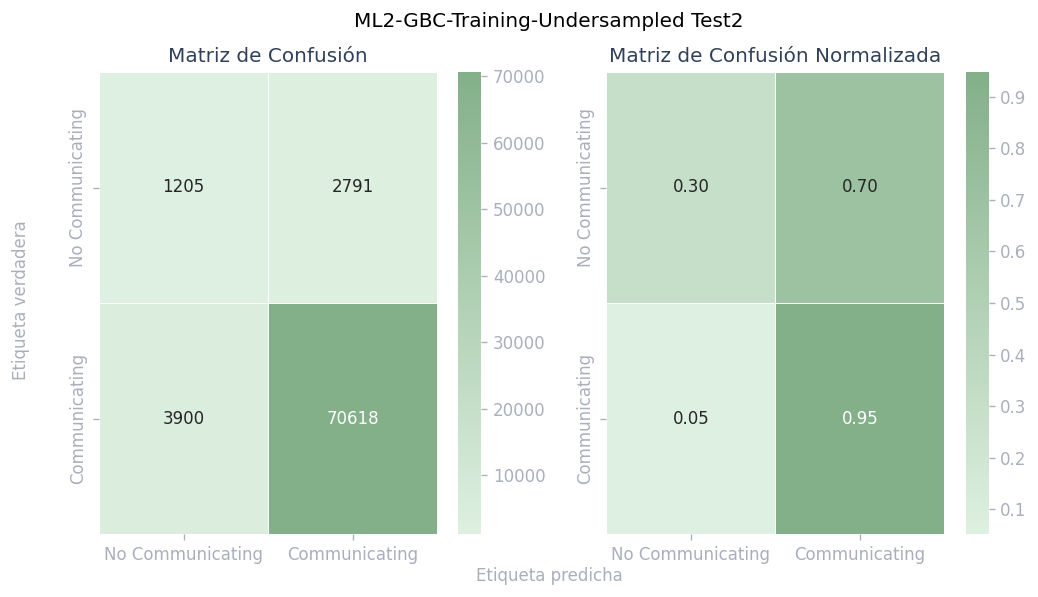

In [ ]:
#GBC ML2 Undersampled
temp_id = get_run_id("ML-2", "gkf_training_us")
temp_randomized_search = mlflow.sklearn.load_model(f"runs:/{temp_id}/RandomizedSearchCV")
temp_model = temp_randomized_search.best_estimator_
metrics_and_cmatrix(temp_model, tests_dic, "ML2-GBC-Training-Undersampled")

Metrics for ML2-GBC-Training-Oversampled Test 1
Accuracy: 0.8757436426761753
F1 Score Micro: 0.8757436426761753
F1 Score Macro: 0.640237414926814
F1 Score Weighted: 0.9078914008480298
Precission: 0.9918684815273113
Recall: 0.8777301969065916
Metrics for ML2-GBC-Training-Oversampled Test 2
Accuracy: 0.8617189291081845
F1 Score Micro: 0.8617189291081845
F1 Score Macro: 0.6034448023421664
F1 Score Weighted: 0.8908997518835884
Precission: 0.9725500675485087
Recall: 0.8791164550846775


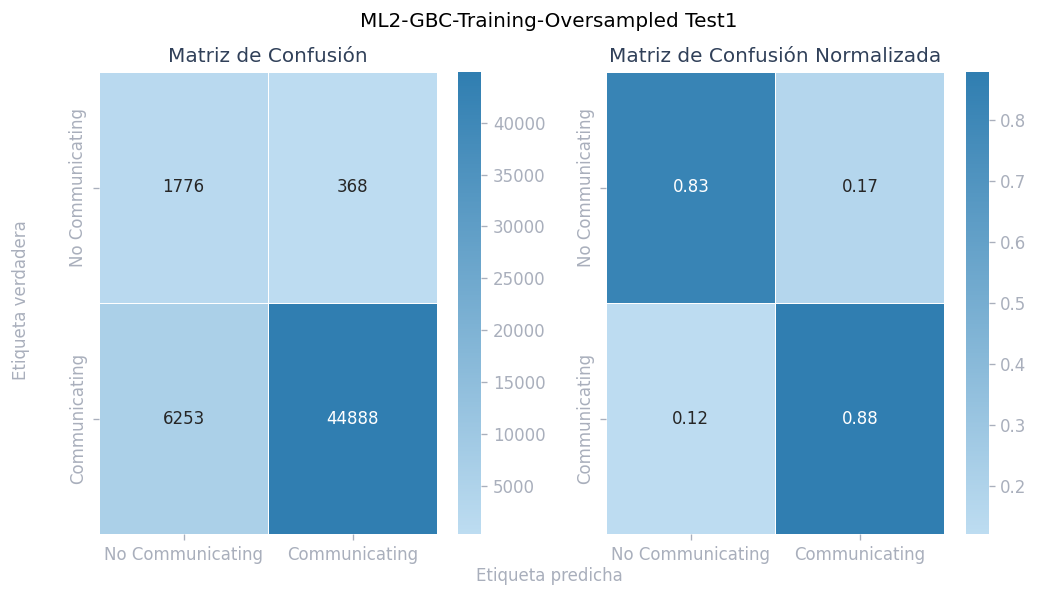

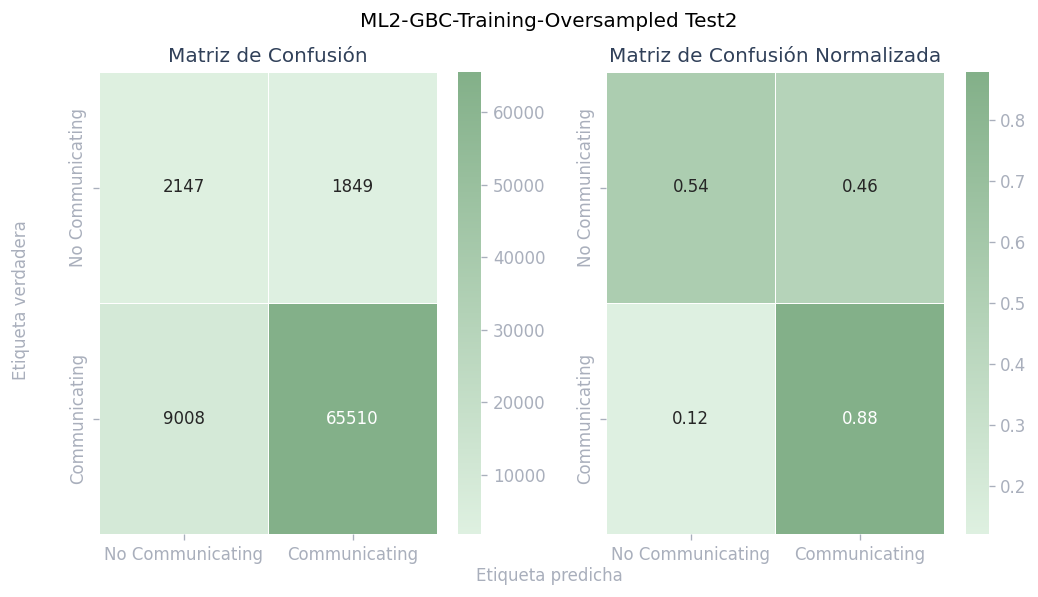

In [ ]:
#GBC ML2 Oversampled
temp_id = get_run_id("ML-2", "gkf_training_os")
temp_randomized_search = mlflow.sklearn.load_model(f"runs:/{temp_id}/RandomizedSearchCV")
temp_model = temp_randomized_search.best_estimator_
metrics_and_cmatrix(temp_model, tests_dic, "ML2-GBC-Training-Oversampled")

### Gradient Boost Classifier ML3

Metrics for ML3-GBC-Training-Undersampled Test 1
Accuracy: 0.9444871915173125
F1 Score Micro: 0.9444871915173125
F1 Score Macro: 0.772652093163337
F1 Score Weighted: 0.9543985435475733
Precission: 0.9970496606078112
Recall: 0.944956101757885
Metrics for ML3-GBC-Training-Undersampled Test 2
Accuracy: 0.9168301194691393
F1 Score Micro: 0.9168301194691393
F1 Score Macro: 0.6346161768861508
F1 Score Weighted: 0.9230468261258469
Precission: 0.9656839913422286
Recall: 0.9459862046753804


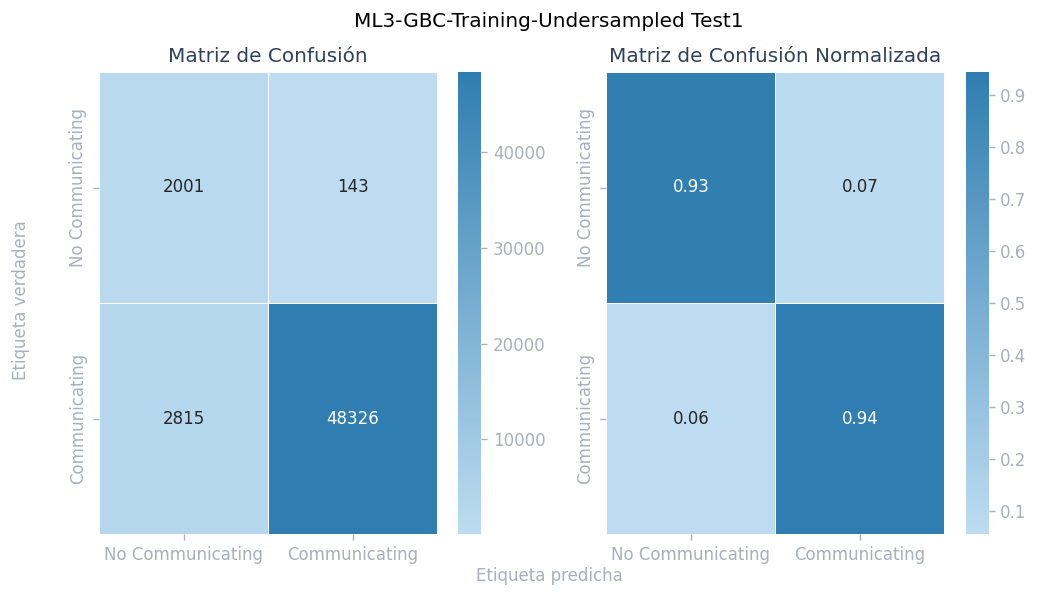

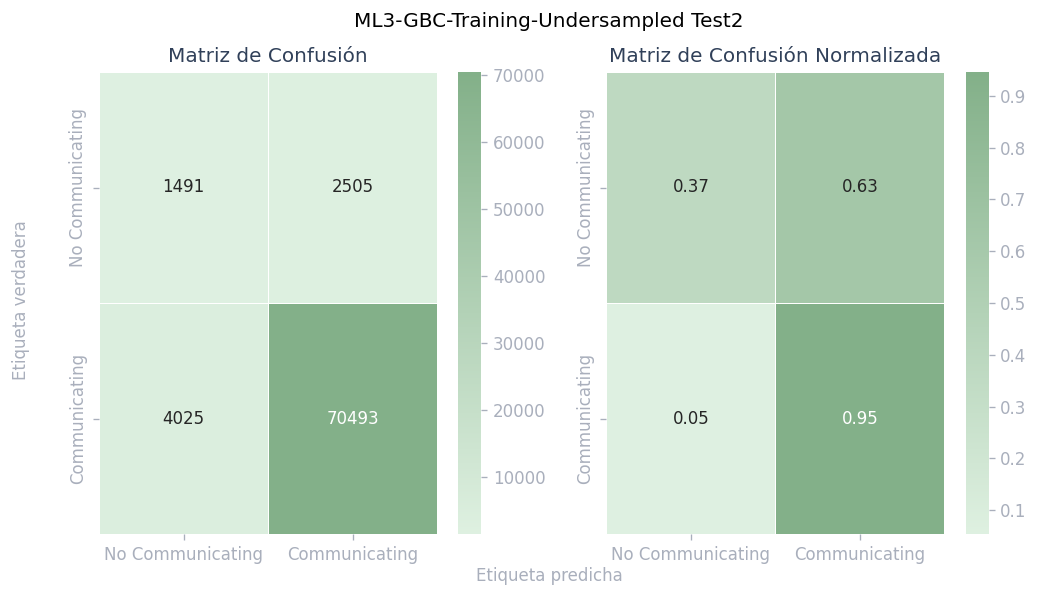

In [ ]:
#GBC ML3 Oversampled
temp_id = get_run_id("ML-3", "gbc_training_us")
temp_randomized_search = mlflow.sklearn.load_model(f"runs:/{temp_id}/RandomizedSearchCV")
temp_model = temp_randomized_search.best_estimator_
metrics_and_cmatrix(temp_model, tests_dic, "ML3-GBC-Training-Undersampled")

Metrics for ML3-GBC-Training-Oversampled Test 1
Accuracy: 0.9599136717650371
F1 Score Micro: 0.9599136717650371
F1 Score Macro: 0.8173224396755909
F1 Score Weighted: 0.9657291478066653
Precission: 0.997805814591333
Recall: 0.9603449287264622
Metrics for ML3-GBC-Training-Oversampled Test 2
Accuracy: 0.9194029090353313
F1 Score Micro: 0.9194029090353313
F1 Score Macro: 0.6030260647599679
F1 Score Weighted: 0.921343815886875
Precission: 0.9601959831551669
Recall: 0.9546552510802759


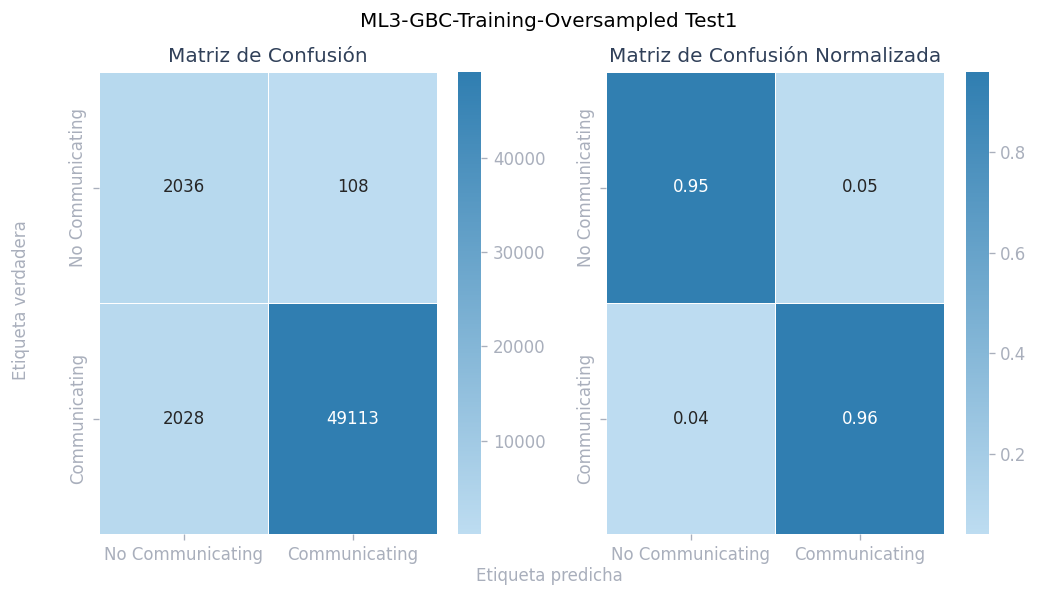

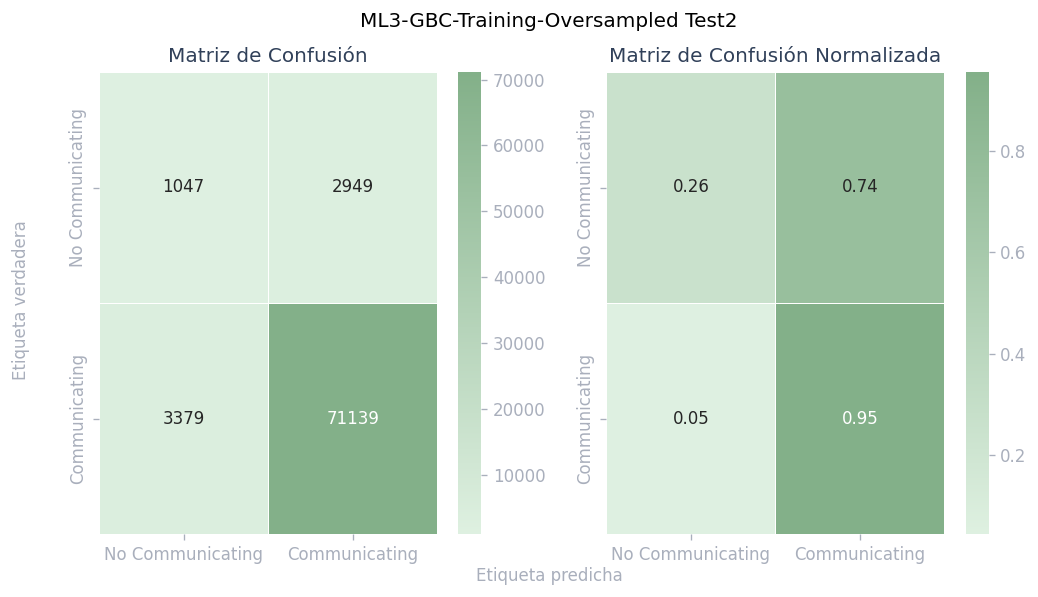

In [ ]:
#GBC ML3 Oversampled
temp_id = get_run_id("ML-3", "gbc_training_os")
temp_randomized_search = mlflow.sklearn.load_model(f"runs:/{temp_id}/RandomizedSearchCV")
temp_model = temp_randomized_search.best_estimator_
metrics_and_cmatrix(temp_model, tests_dic, "ML3-GBC-Training-Oversampled")

## Support Vector Machine

### Support Vector Machine ML

Metrics for ML-SVM-Training-Undersampled Test 1
Accuracy: 0.9022238904006756
F1 Score Micro: 0.9022238904006756
F1 Score Macro: 0.6883754934247245
F1 Score Weighted: 0.9257495879543156
Precission: 0.9961758669115264
Recall: 0.901585811775288
Metrics for ML-SVM-Training-Undersampled Test 2
Accuracy: 0.8673994446850243
F1 Score Micro: 0.8673994446850243
F1 Score Macro: 0.574162833861682
F1 Score Weighted: 0.8915639093069226
Precission: 0.9635424951915429
Recall: 0.8941195415872675


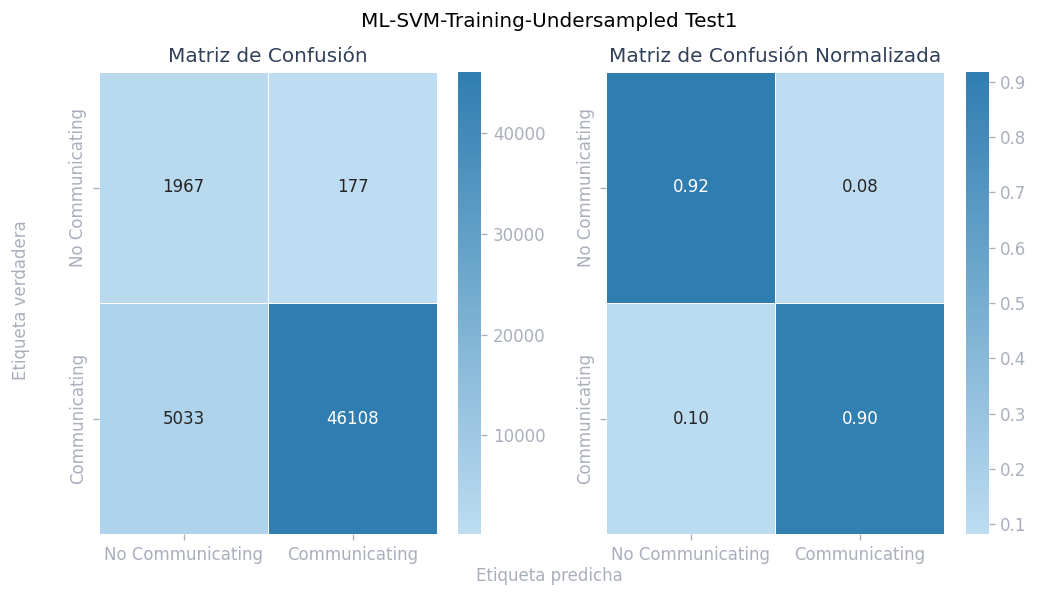

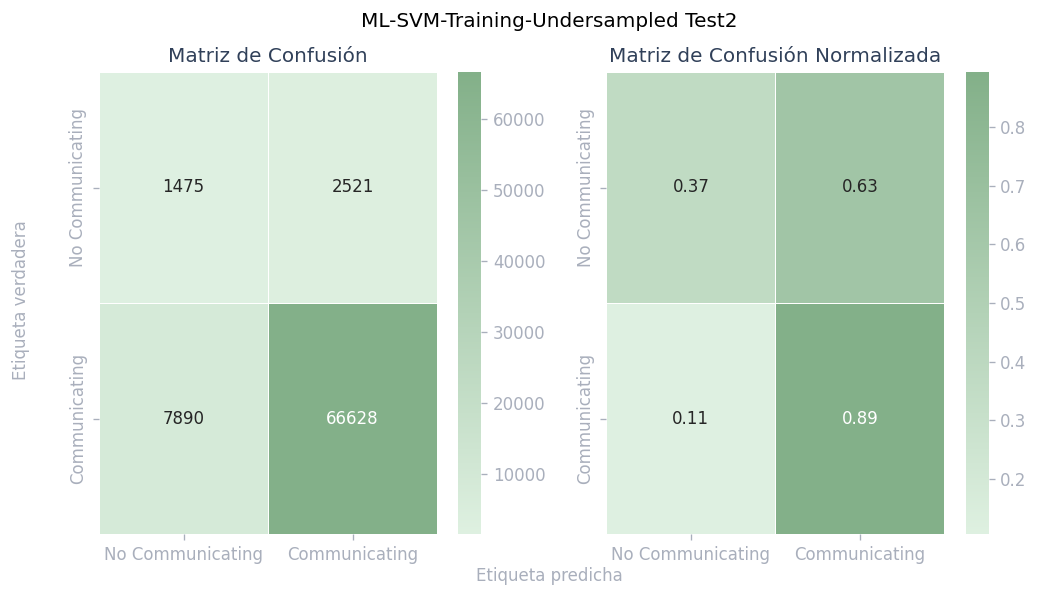

In [ ]:
#GBC ML2 Oversampled
temp_id = get_run_id("ML", "SVM-Undersampled-3")
temp_randomized_search = mlflow.sklearn.load_model(f"runs:/{temp_id}/RandomizedSearchCV")
temp_model = temp_randomized_search.best_estimator_
metrics_and_cmatrix(temp_model, tests_dic, "ML-SVM-Training-Undersampled")

### Support Vector Machine ML3

Metrics for ML3-SVM-Training-Undersampled Test 1
Accuracy: 0.8953551656188421
F1 Score Micro: 0.8953551656188421
F1 Score Macro: 0.6777435694476881
F1 Score Weighted: 0.9212477002992658
Precission: 0.9960157627745967
Recall: 0.8945464500107546
Metrics for ML3-SVM-Training-Undersampled Test 2
Accuracy: 0.8670173472246988
F1 Score Micro: 0.8670173472246988
F1 Score Macro: 0.5665698436190046
F1 Score Weighted: 0.8907014480382365
Precission: 0.9618827939162402
Recall: 0.895367562199737


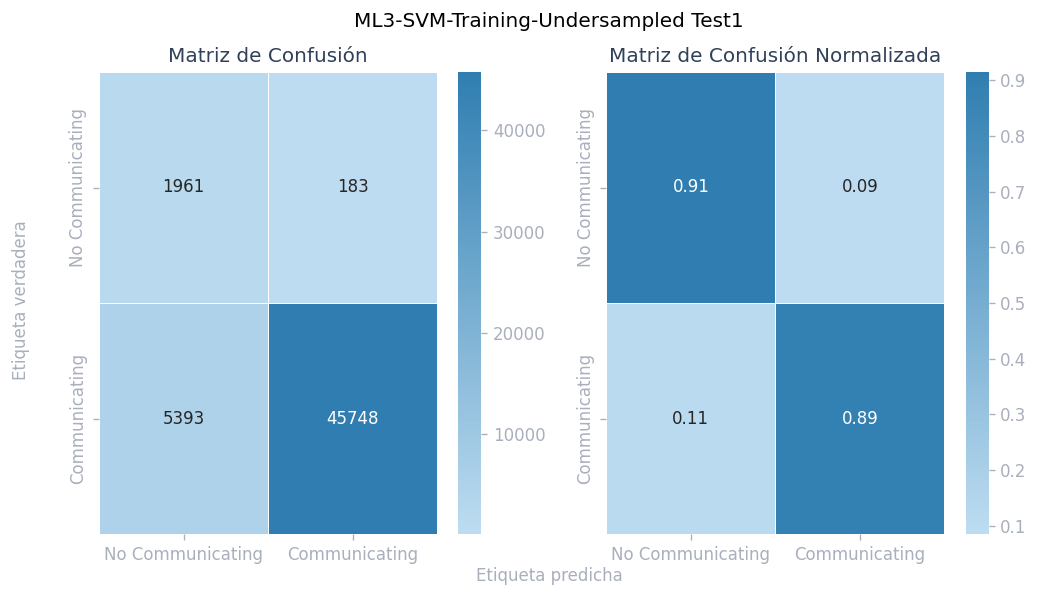

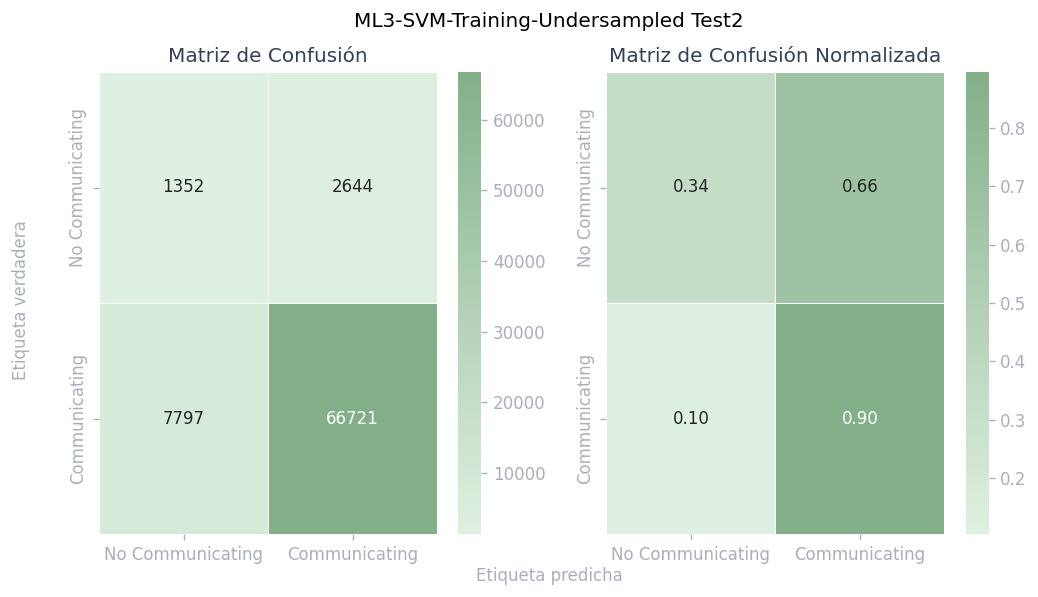

In [ ]:
#GBC ML2 Oversampled
temp_id = get_run_id("ML-3", "SVM-undersampled")
temp_randomized_search = mlflow.sklearn.load_model(f"runs:/{temp_id}/RandomizedSearchCV")
temp_model = temp_randomized_search.best_estimator_
metrics_and_cmatrix(temp_model, tests_dic, "ML3-SVM-Training-Undersampled")